In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

In [2]:
import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [3]:
# download dataset
# file_index='SSSBSSSS'

file_index='SSSBSSSS'
data_dir='../../Data/Weather'
filebase='US_Weather_%s'%file_index
!rm -rf $data_dir/$filebase*
c_filename = filebase + '.csv.gz'
u_filename = filebase + '.csv'
command = "curl https://mas-dse-open.s3.amazonaws.com/Weather/small/%s > %s/%s"%(c_filename,data_dir,c_filename)
print command
!$command
!ls -lh $data_dir/$c_filename

curl https://mas-dse-open.s3.amazonaws.com/Weather/small/US_Weather_SSSBSSSS.csv.gz > ../../Data/Weather/US_Weather_SSSBSSSS.csv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2640k  100 2640k    0     0  1489k      0  0:00:01  0:00:01 --:--:-- 1520k
-rw-r--r--  1 xupei  staff   2.6M May 15 19:41 ../../Data/Weather/US_Weather_SSSBSSSS.csv.gz


In [4]:
#unzip
!gunzip -c $data_dir/$c_filename > $data_dir/$u_filename
import pickle
List=pickle.load(open(data_dir+'/'+u_filename,'rb'))
len(List)

12741

In [5]:
# create dataframe
df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

12741
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[B8 59 00 58 38 5...|2002.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[90 59 10 5A 20 5...|2003.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     1|[E0 55 00 58 E0 5...|2004.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[50 57 90 55 A0 5...|2005.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     7|[A0 56 F0 56 A0 5...|2006.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [6]:
#store dataframe as parquet file
outfilename=data_dir+'/'+filebase+'.parquet'
!rm -rf $outfilename
df.write.save(outfilename)

In [7]:
# Compare file sizes
!du -sh $data_dir/$filebase*

 12M	../../Data/Weather/US_Weather_SSSBSSSS.csv
2.6M	../../Data/Weather/US_Weather_SSSBSSSS.csv.gz
3.0M	../../Data/Weather/US_Weather_SSSBSSSS.parquet


In [8]:
measurements=['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']

In [9]:
sqlContext.registerDataFrameAsTable(df,'weather') #using older sqlContext instead of newer (V2.0) sparkSession

In [10]:
df.show(20)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[B8 59 00 58 38 5...|2002.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[90 59 10 5A 20 5...|2003.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     1|[E0 55 00 58 E0 5...|2004.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[50 57 90 55 A0 5...|2005.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     7|[A0 56 F0 56 A0 5...|2006.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[80 58 B8 59 C8 5...|2007.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     5|[48 5B 40 5A 28 5...|2008.0|SSSBSSSS|
|    402.9

In [11]:
from numpy import linalg as LA
from time import time
STAT={}  # dictionary storing the statistics for each measurement
Clean_Tables={}

for meas in measurements:
    t=time()
    Query="SELECT * FROM weather\n\tWHERE measurement = '%s'"%(meas)
    print Query
    df = sqlContext.sql(Query)
    data = df.rdd.map(lambda row: unpackArray(row['vector'],np.float16))
    #get very basic statistics
    STAT[meas]=computeOverAllDist(data)   # Compute the statistics 

    # compute covariance matrix
    OUT=computeCov(data)

    #find PCA decomposition
    eigval,eigvec=LA.eig(OUT['Cov'])

    # collect all of the statistics in STAT[meas]
    STAT[meas]['eigval']=eigval
    STAT[meas]['eigvec']=eigvec
    STAT[meas].update(OUT)

    print 'time for',meas,'is',time()-t

SELECT * FROM weather
	WHERE measurement = 'TMAX'
shape of E= (365,) shape of NE= (365,)
time for TMAX is 27.7553172112
SELECT * FROM weather
	WHERE measurement = 'SNOW'
shape of E= (365,) shape of NE= (365,)
time for SNOW is 23.2472579479
SELECT * FROM weather
	WHERE measurement = 'SNWD'
shape of E= (365,) shape of NE= (365,)
time for SNWD is 23.6458230019
SELECT * FROM weather
	WHERE measurement = 'TMIN'
shape of E= (365,) shape of NE= (365,)
time for TMIN is 20.6474781036
SELECT * FROM weather
	WHERE measurement = 'PRCP'
shape of E= (365,) shape of NE= (365,)
time for PRCP is 30.3450739384
SELECT * FROM weather
	WHERE measurement = 'TOBS'
shape of E= (365,) shape of NE= (365,)
time for TOBS is 10.8253910542


In [12]:
from pickle import dump
filename=data_dir+'/STAT_%s.pickle'%file_index
dump((STAT,STAT_Descriptions),open(filename,'wb'))

In [13]:
### Read the data frame from pickle file

from pickle import load

#read statistics
filename = data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename = data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12741
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[B8 59 00 58 38 5...|2002.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[90 59 10 5A 20 5...|2003.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     1|[E0 55 00 58 E0 5...|2004.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[50 57 90 55 A0 5...|2005.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     7|[A0 56 F0 56 A0 5...|2006.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



Populating the interactive namespace from numpy and matplotlib
SELECT * FROM weather
	WHERE measurement = 'TMIN'


/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(2172, 365)


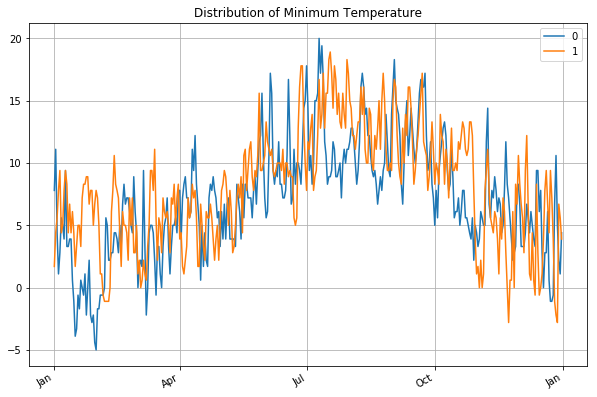

In [14]:
import sys
sys.path.append('./lib')
import pandas as pd
import sklearn as sk
import urllib
import math
%pylab inline
from YearPlotter import YearPlotter

# DISTRIBUTION OF TMIN
Query="SELECT * FROM weather\n\tWHERE measurement = '%s'"%('TMIN')
print Query
df_tmin = sqlContext.sql(Query)
data_tmin = df_tmin.rdd.map(lambda row: unpackArray(row['vector'],np.float16))
fig, ax = plt.subplots(figsize=(10,7));
YP = YearPlotter()
rows = data_tmin.collect()
T = np.vstack(rows)
T = T / 10.  # scaling to make the temperature be in centingrates
print shape(T)
YP.plot(T[:2,:].transpose(),fig,ax,title='TMIN')
title('Distribution of Minimum Temperature');

In [15]:
# DISTRIBUTION OF MISSING OBSERVATIONS
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)

/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


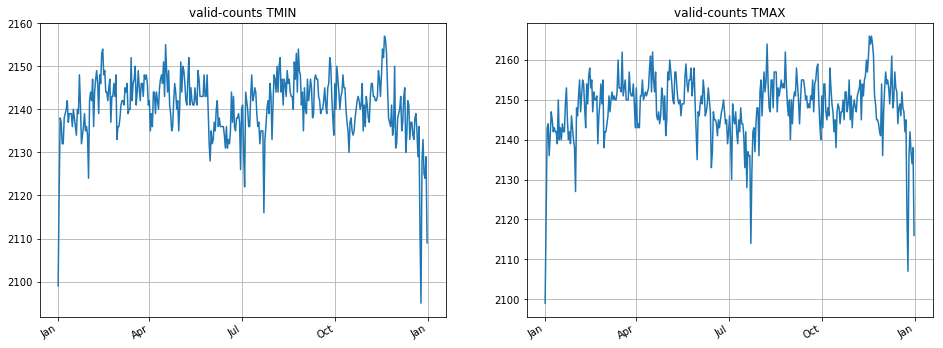

In [16]:
plot_pair(['TMIN','TMAX'],plot_valid)

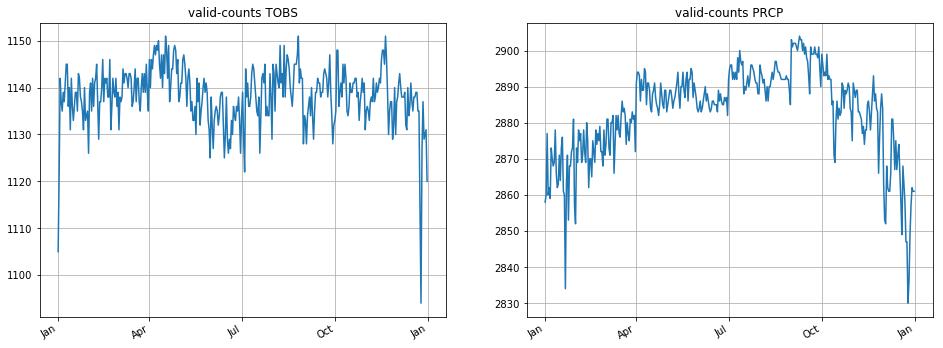

In [17]:
plot_pair(['TOBS','PRCP'],plot_valid)

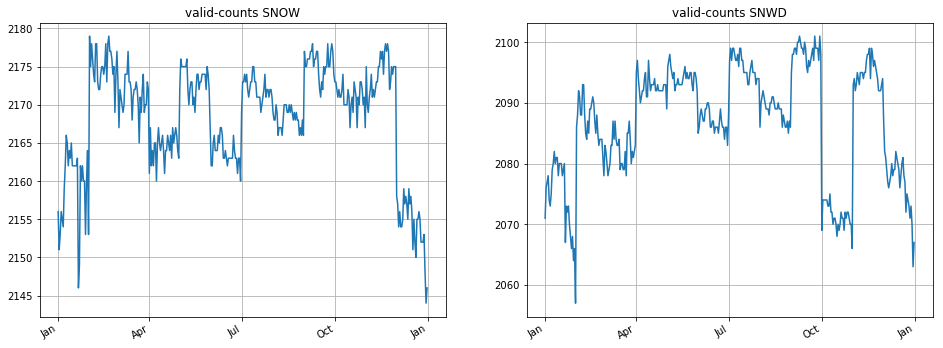

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

In [19]:
# MEAN AND STD OF OBSERVATION
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std ' + m)
    plt.xlabel('month')
    plt.ylabel('F')

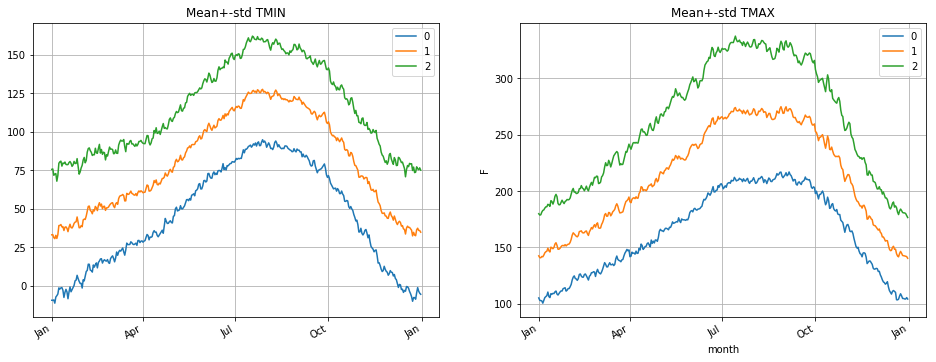

In [20]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

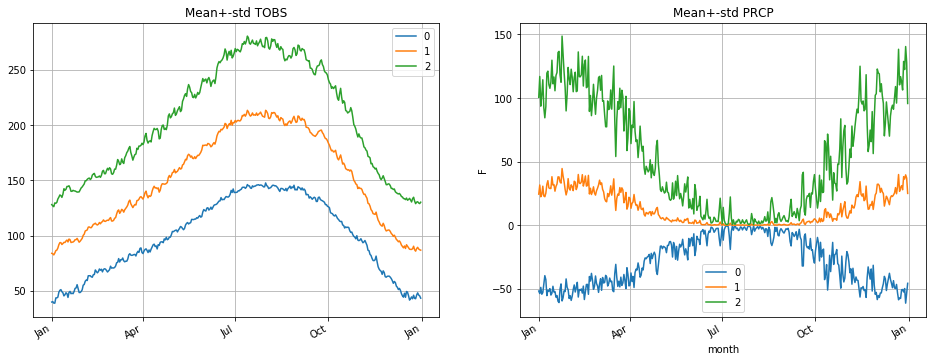

In [21]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

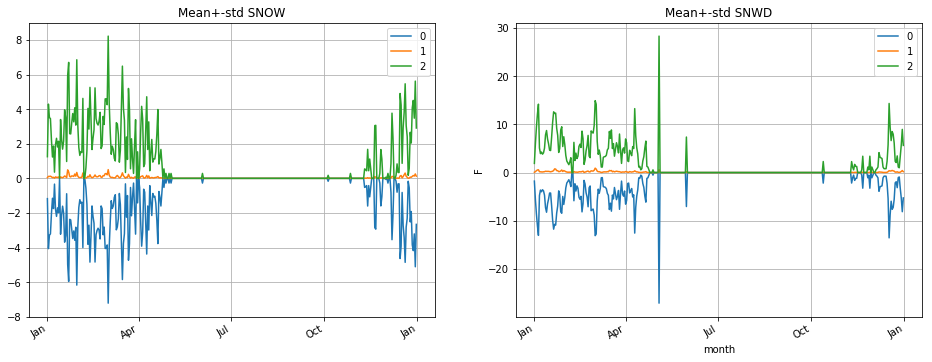

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

In [23]:
# PLOT TOP3 EIGENVECTORS
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

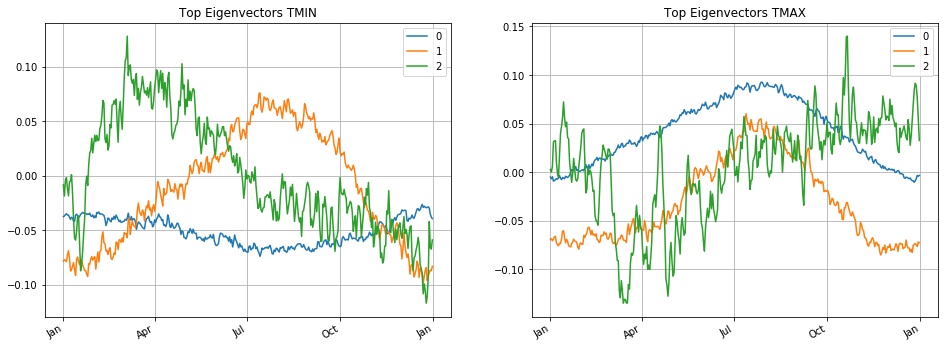

In [24]:
plot_pair(['TMIN','TMAX'],plot_eigen)

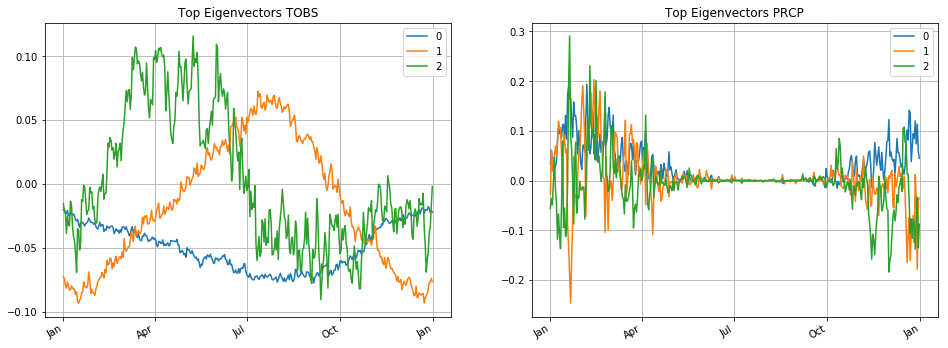

In [25]:
plot_pair(['TOBS','PRCP'],plot_eigen)

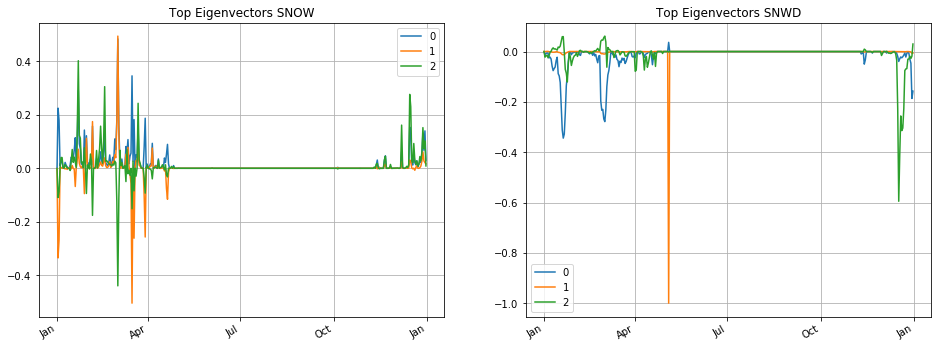

In [26]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

In [27]:
# PLOT PERCENTAGE OF VARIANCE EXPLAINED
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

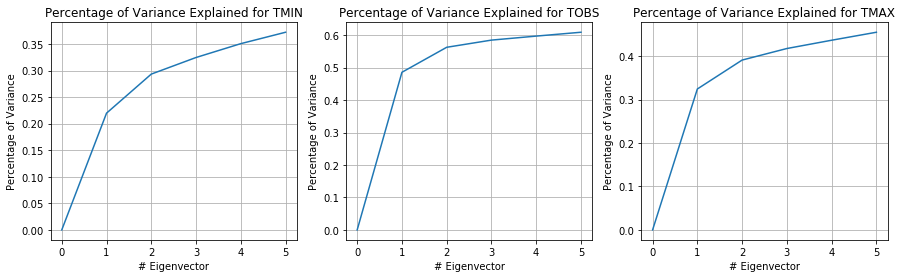

In [28]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

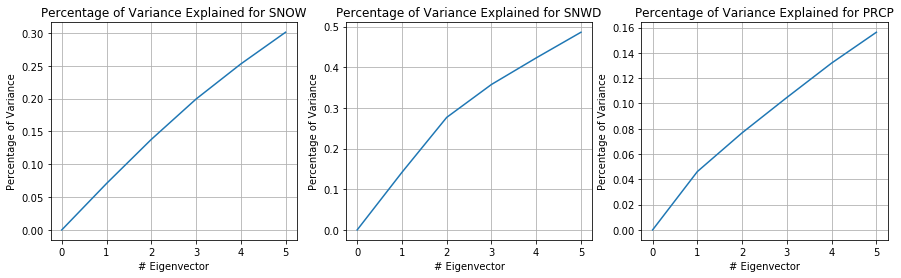

In [29]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [30]:
from Eigen_decomp import Eigen_decomp
from recon_plot import recon_plot
from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [31]:
# PLOT TWO TIME SERIES
df_0 = df.filter(df.measurement == measurements[0])
df_0.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[B8 59 00 58 38 5...|2002.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[90 59 10 5A 20 5...|2003.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     1|[E0 55 00 58 E0 5...|2004.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[50 57 90 55 A0 5...|2005.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     7|[A0 56 F0 56 A0 5...|2006.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



(2179, 365)


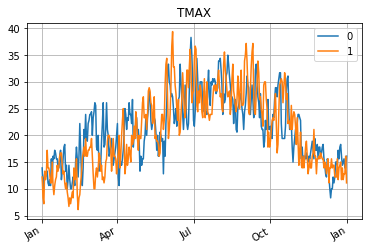

In [32]:
rows_0 = df_0.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T_0 = np.vstack(rows_0) / 10.
print shape(T_0)
fig, ax = plt.subplots(figsize=(6,4));
YP = YearPlotter()
YP.plot(T_0[16:18].transpose(),fig,ax,title = measurements[0])

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     29.0| 36.9308|-121.7692|       SNOW|USC00049473|    30|[00 00 00 00 00 0...|1945.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNOW|USC00049473|     0|[00 00 00 00 00 0...|1946.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNOW|USC00049473|     0|[00 00 00 00 00 0...|1947.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNOW|USC00049473|     3|[00 00 00 00 00 0...|1948.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNOW|USC00049473|     0|[00 00 00 00 00 0...|1949.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



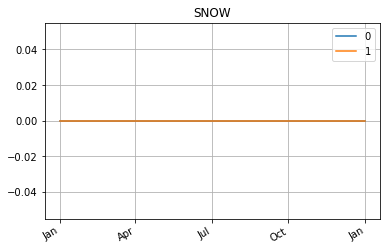

In [33]:
df_1 = df.filter(df.measurement == measurements[1])
df_1.show(5)
rows_1 = df_1.rdd.map(lambda row:unpackArray(row['vector'], np.float16)).collect()
T_1 = np.vstack(rows_1)
fig, ax = plt.subplots(figsize = (6, 4));
YP = YearPlotter()
YP.plot(T_1[16:18].transpose(), fig, ax, title = measurements[1])

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     0|[00 00 00 00 00 0...|1949.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     0|[00 00 00 00 00 0...|1950.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|    11|[00 00 00 00 00 0...|1951.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     3|[00 00 00 00 00 0...|1952.0|SSSBSSSS|
|     29.0| 36.9308|-121.7692|       SNWD|USC00049473|     4|[00 00 00 00 00 0...|1953.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



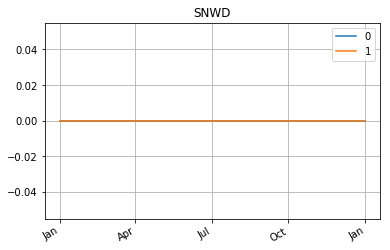

In [34]:
df_2 = df.filter(df.measurement == measurements[2])
df_2.show(5)
rows_2 = df_2.rdd.map(lambda row:unpackArray(row['vector'], np.float16)).collect()
T_2 = np.vstack(rows_2)
fig, ax = plt.subplots(figsize = (6, 4));
YP = YearPlotter()
YP.plot(T_2[16:18].transpose(), fig, ax, title = measurements[2])

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    402.9| 36.4708|-121.1472|       TMIN|USR0000CPNN|     0|[E0 54 F0 56 80 5...|2002.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMIN|USR0000CPNN|     0|[40 4C 80 51 00 5...|2003.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMIN|USR0000CPNN|     1|[30 54 40 4C 00 C...|2004.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMIN|USR0000CPNN|     0|[40 52 E0 50 E0 5...|2005.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMIN|USR0000CPNN|     0|[E0 50 30 54 E0 5...|2006.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



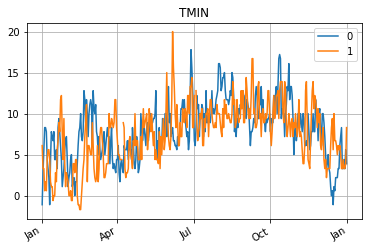

In [35]:
df_3 = df.filter(df.measurement == measurements[3])
df_3.show(5)
rows_3 = df_3.rdd.map(lambda row:unpackArray(row['vector'], np.float16)).collect()
T_3 = np.vstack(rows_3) / 10.
fig, ax = plt.subplots(figsize = (6, 4));
YP = YearPlotter()
YP.plot(T_3[16:18].transpose(), fig, ax, title = measurements[3])

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    716.9| 36.5333|-121.2833|       PRCP|USC00043502|     9|[20 51 00 00 00 0...|1949.0|SSSBSSSS|
|    716.9| 36.5333|-121.2833|       PRCP|USC00043502|     4|[00 00 A0 53 00 0...|1950.0|SSSBSSSS|
|    335.3|  36.398|-121.8685|       PRCP|US1CAMT0023|    35|[00 7E 00 7E 00 7...|2010.0|SSSBSSSS|
|    335.3|  36.398|-121.8685|       PRCP|US1CAMT0023|     4|[80 4C B4 5E 00 5...|2011.0|SSSBSSSS|
|    335.3|  36.398|-121.8685|       PRCP|US1CAMT0023|     6|[00 00 00 00 00 0...|2012.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



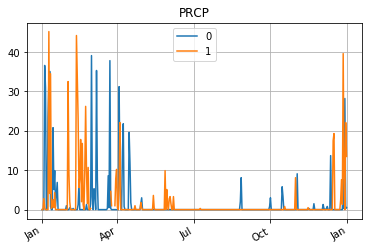

In [36]:
df_4 = df.filter(df.measurement == measurements[4])
df_4.show(5)
rows_4 = df_4.rdd.map(lambda row:unpackArray(row['vector'], np.float16)).collect()
T_4 = np.vstack(rows_4) / 10.
fig, ax = plt.subplots(figsize = (6, 4));
YP = YearPlotter()
YP.plot(T_4[16:18].transpose(), fig, ax, title = measurements[4])

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     2|[80 58 00 58 58 5...|1940.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|    16|[30 54 40 56 40 5...|1941.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     0|[00 53 30 54 30 5...|1942.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     0|[F0 56 40 56 A0 5...|1943.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     0|[50 57 40 56 30 5...|1944.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



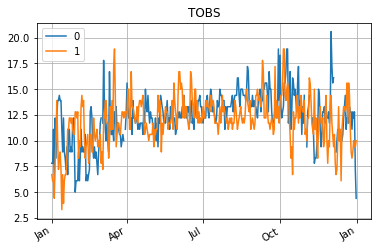

In [37]:
df_5 = df.filter(df.measurement == measurements[5])
df_5.show(5)
rows_5 = df_5.rdd.map(lambda row:unpackArray(row['vector'], np.float16)).collect()
T_5 = np.vstack(rows_5) / 10.
fig, ax = plt.subplots(figsize = (6, 4));
YP = YearPlotter()
YP.plot(T_5[16:18].transpose(), fig, ax, title = measurements[5])

# PCA Analysis of TOBS

In [38]:
m = 'TOBS'

In [40]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df_t = df_in.filter(df_in.measurement==m)
df_t.show(5)
rows_t = df_t.rdd.map(lambda row:unpackArray(row['vector'], np.float16)).collect()
T_t = np.vstack(rows_t)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     2|[80 58 00 58 58 5...|1940.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|    16|[30 54 40 56 40 5...|1941.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     0|[00 53 30 54 30 5...|1942.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     0|[F0 56 40 56 A0 5...|1943.0|SSSBSSSS|
|      8.2| 37.4725|-122.4433|       TOBS|USC00043714|     0|[50 57 40 56 30 5...|1944.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



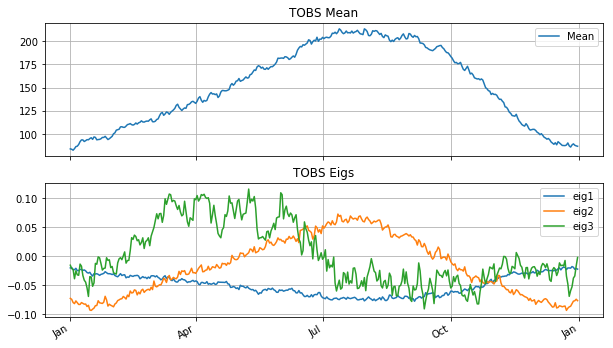

In [41]:
# Plot Reconstructions
fig,axes = plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec =np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

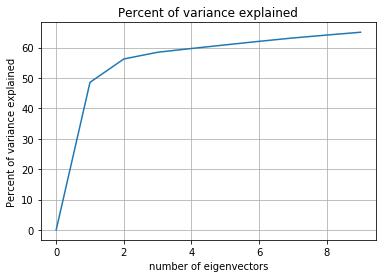

In [42]:
# plot the percent of residual variance on average
fig, ax = plt.subplots(1, 1);
eigvals = STAT[m]['eigval']; eigvals /= sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
# print eigvals
ax.plot(cumvar[:10]);
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');ax.grid()


In [77]:
rdd2 = df_t.rdd.map(decompose)
df2 = sqlContext.createDataFrame(rdd2)
row,= df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1163
after filter 1163


In [45]:
# the earliest and the most recent year
rows_year = df_t.rdd.map(lambda row: (row.station, row.year, unpackArray(row['vector'], np.float16))).collect()
print rows_year[0][:2]
days = set([r[1] for r in rows_year])
miny = min(days)
maxy = max(days)
record_len = int((maxy - miny + 1) * 365)
print miny, maxy, record_len

(u'USC00043714', 1940.0)
1901.0 2012.0 40880


In [46]:
# combine the measurements for each station into a single long array with an entry for each day of each day
All = {}
i = 0
for station, day, vector in rows_year:
    i += 1
    if not station in All:
        a = np.zeros(record_len)
        a.fill(np.nan)
        All[station] = a
    loc = int((day - miny) * 365)
    All[station][loc : loc + 365] = vector

In [47]:
from datetime import date
d = datetime.date(int(miny), month=1, day=1)
start = d.toordinal()
dates = [date.fromordinal(i) for i in range(start, start + record_len)]
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00043714 23266
USC00040673 14424
USC00040677 1792
USC00049792 7330
USC00047807 18537
USC00040674 10119
USC00047821 10693
USC00044555 13026
USC00047846 15589
USC00042362 5341
USC00043004 2450
USC00046646 10452
USC00048273 4706
USC00046168 19286
USC00046642 5049
USC00046926 21395
USC00045119 1024
USC00045933 16580
USC00045802 5791
USC00047912 8141
USC00041534 10498
USC00047916 14652
USC00045550 364
USC00040676 361
USC00045118 15437
USC00049473 24640
USC00045795 21832
USC00046610 2449
USC00045120 12674
USW00023259 1341
USC00040790 4913
USC00043417 17035
USC00047668 15559
USC00047339 18656
USC00044025 2492
USC00044022 11881
USC00045123 25712


In [48]:
# statistics by station and by day
Stations = sorted(All.keys())
A = []
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(37, 40880)


In [49]:
# Root Mean Square of day station
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day = np.nanmean(day_station_table, axis=0)
mean_by_station = np.nanmean(day_station_table, axis=1)
tbl_minus_day = day_station_table - mean_by_day
tbl_minus_station = (day_station_table.transpose() - mean_by_station).transpose()

print 'total RMS                   = ', RMS(day_station_table)
print 'RMS removing mean-by-station= ', RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ', RMS(tbl_minus_day)

total RMS                   =  166.354918324
RMS removing mean-by-station=  60.860945014
RMS removing mean-by-day   =  45.942894723


/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [51]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [52]:
# USC00043714 23618
# USC00040673 13653
X=copy(All['USC00043714'])
Y=copy(All['USC00040673'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))

23266
14424
12389
12389


In [53]:
# calculate the normalized log probability for each pair of stations
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

(-0.00054774327133077323, 12389)
0 1 2 3 4 5 6 7 8 9

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36


In [56]:
# Interactive plot of reconstruction
i = 10
print EigVec
print shape(EigVec)
v = [np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
print shape(v)
eigen_decomp = Eigen_decomp(None, T_t[i], Mean, v)
total_var,residuals,reductions,coeff = eigen_decomp.compute_var_explained()
res = residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

[[-0.02000199 -0.07236203 -0.01533961]
 [-0.01937101 -0.07400477 -0.02121646]
 [-0.02301229 -0.07948322 -0.02256163]
 ..., 
 [-0.02232956 -0.07644284 -0.03380461]
 [-0.0209053  -0.0738323  -0.0165692 ]
 [-0.02209165 -0.07630592 -0.0020282 ]]
(365, 3)
(3, 365)
residual normalized norm  after mean: 0.0734317048122
residual normalized norm  after mean + top eigs: [ 0.52056662  0.27601201  0.26945704]


[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[-0.4  nan]
 [ nan -0.4]]
(1369,) (1017,)


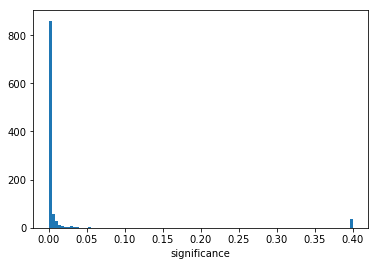

In [57]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

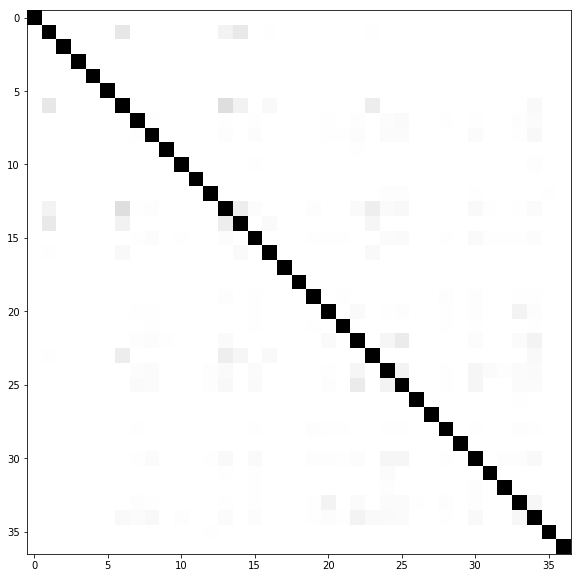

In [58]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)
showmat(P_norm)

A group of very correlated stations is: [u'USC00043714', u'USC00040673', u'USC00040677', u'USC00049792', u'USC00047807', u'USC00040674', u'USC00047821', u'USC00044555']


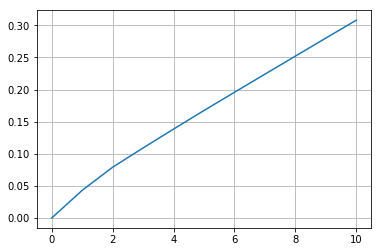

In [59]:
print 'A group of very correlated stations is:',All.keys()[:8]
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

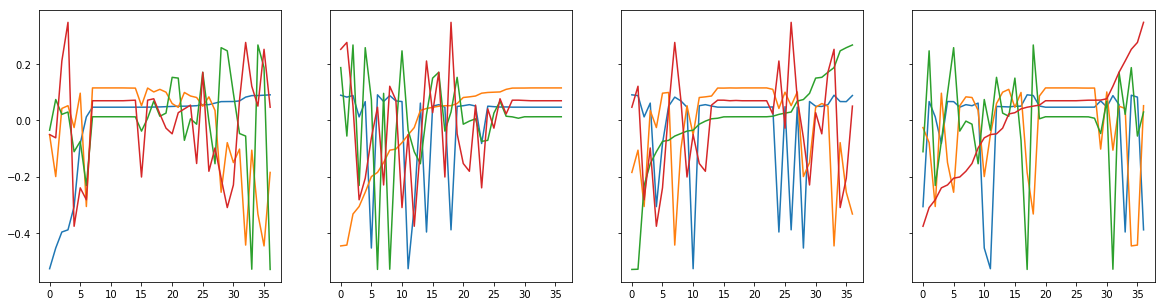

In [60]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

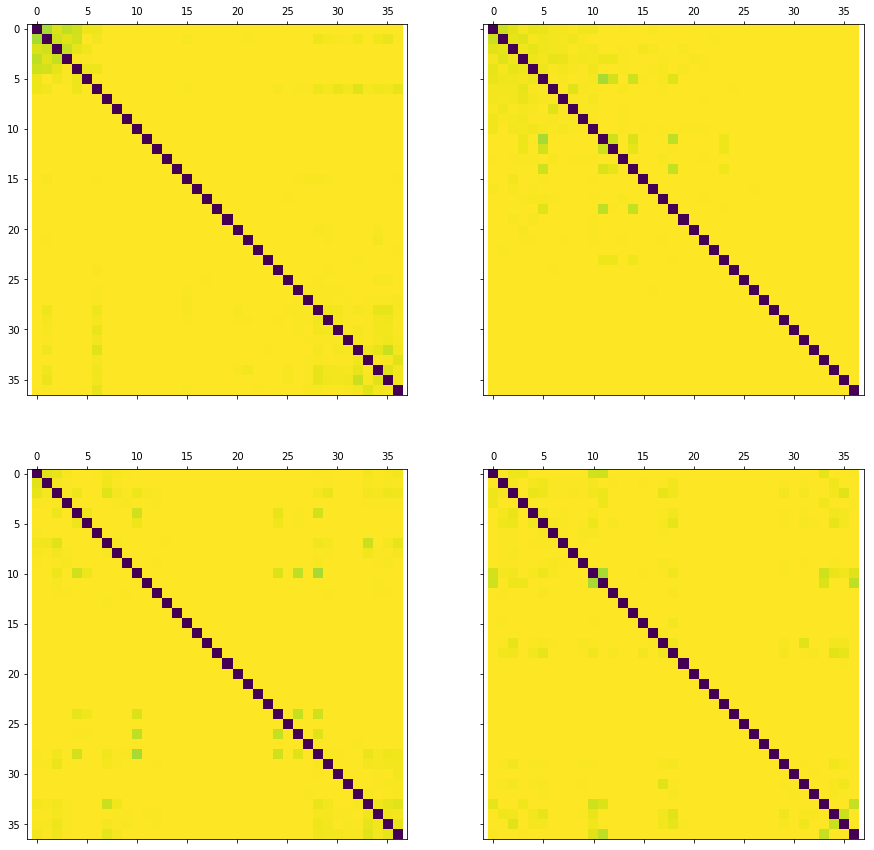

In [61]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1

In [62]:
from pickle import dump
with open(data_dir+'/TOBS_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    

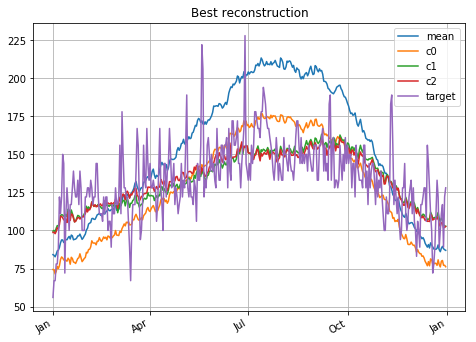

In [63]:
plotter = recon_plot(eigen_decomp, year_axis=True, interactive=True)
display(plotter.get_Interactive())

In [64]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

In [102]:
# Add to each row in the dataframe a residual values
# Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.
# decompose(row) axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.
rdd2 = df_t.rdd.map(decompose)
df2 = sqlContext.createDataFrame(rdd2)
row, = df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter', df2.count()
df3 = df2.filter(df2.res_mean < 1)
print 'after filter', df3.count()

before filter 1163
after filter 1163


In [103]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None

In [104]:
def plot_decomp1(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid1(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
#             _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
#                     %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            _title='c1=%3.2f,r1=%3.2f'\
                    %(row['coeff_1'],row['res_1'])
            #print i,j,_title,axes[i,j]
            plot_decomp1(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None
def plot_recon_grid2(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
#             _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
#                     %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            _title='c2=%3.2f,r1=%3.2f'\
                    %(row['coeff_2'],row['res_1'])
            #print i,j,_title,axes[i,j]
            plot_decomp1(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None

def plot_recon_grid3(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
#             _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
#                     %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            _title='c3=%3.2f,r1=%3.2f'\
                    %(row['coeff_3'],row['res_1'])
            #print i,j,_title,axes[i,j]
            plot_decomp1(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None

## most positive coefficient1

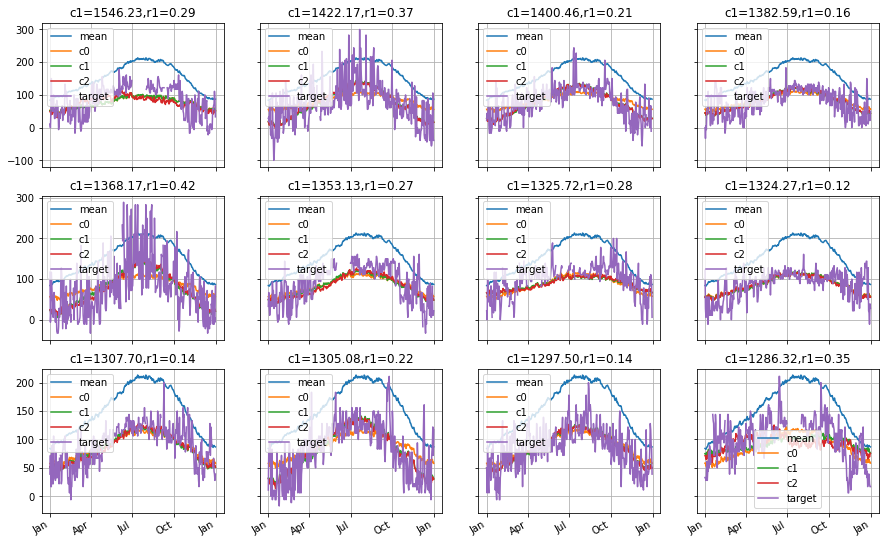

In [105]:
df5 = df3.sort(df3.coeff_1,ascending = False)
rows = df5.take(12)
plot_recon_grid1(rows)

## most negative coefficient1

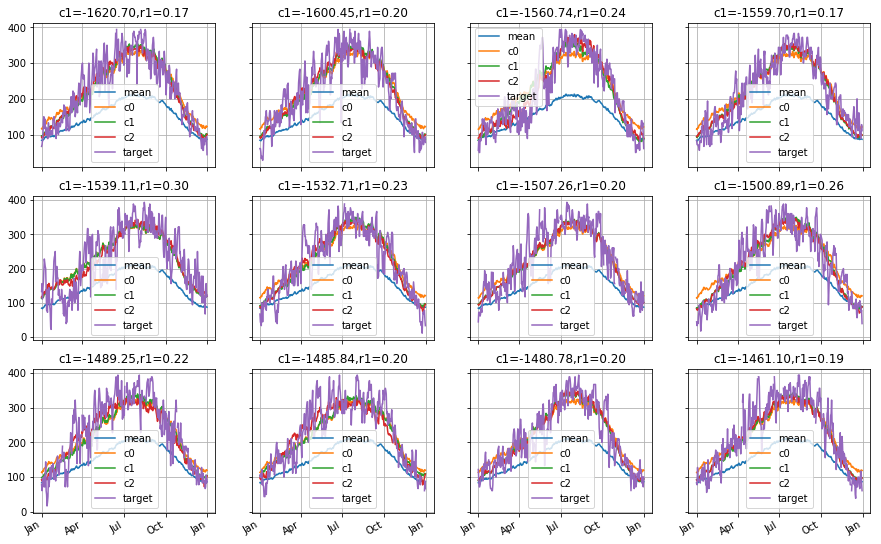

In [106]:
df6 = df3.sort(df3.coeff_1)
rows = df6.take(12)
plot_recon_grid1(rows)

## most positive c2

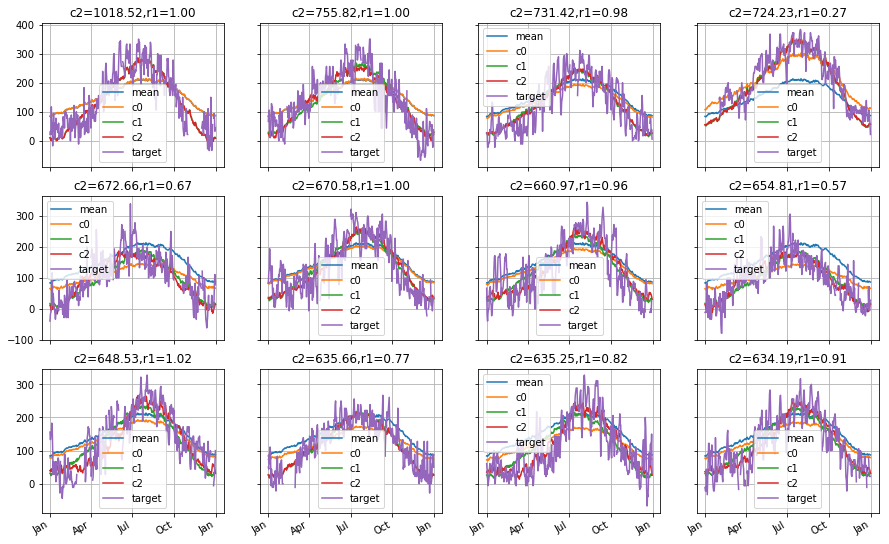

In [109]:
df7 = df3.sort(df3.coeff_2, ascending = False)
rows = df7.take(12)
plot_recon_grid2(rows)

## most negative c2

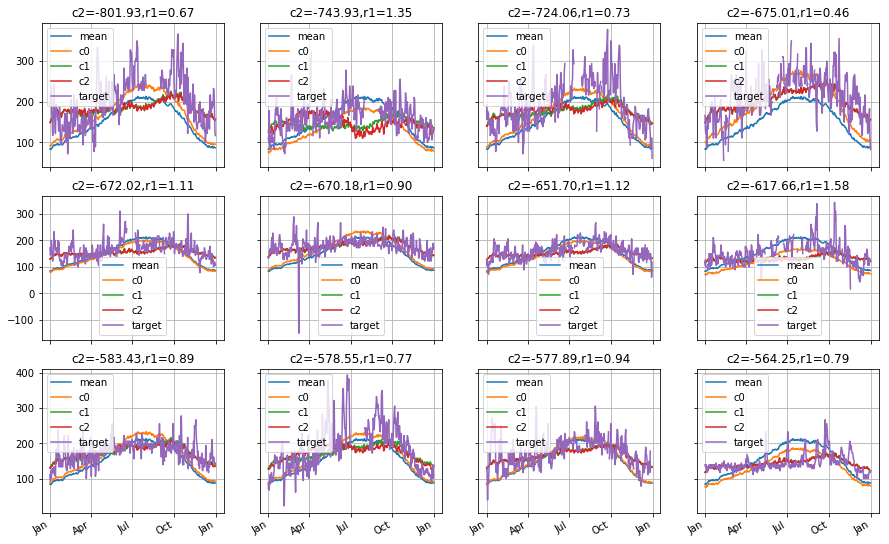

In [110]:
df8 = df3.sort(df3.coeff_2)
rows = df8.take(12)
plot_recon_grid2(rows)

## most positive c3

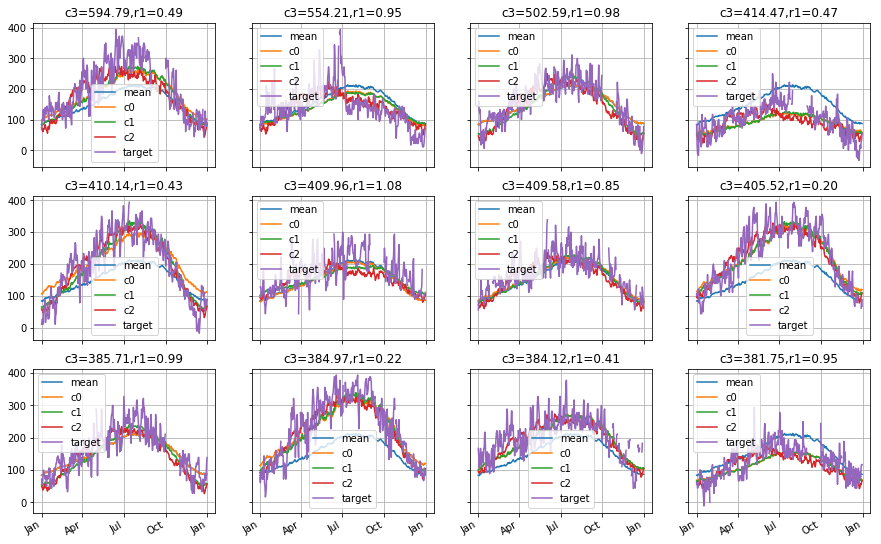

In [111]:
df9 = df3.sort(df3.coeff_3, ascending = False)
rows = df9.take(12)
plot_recon_grid3(rows)

## most negative c3

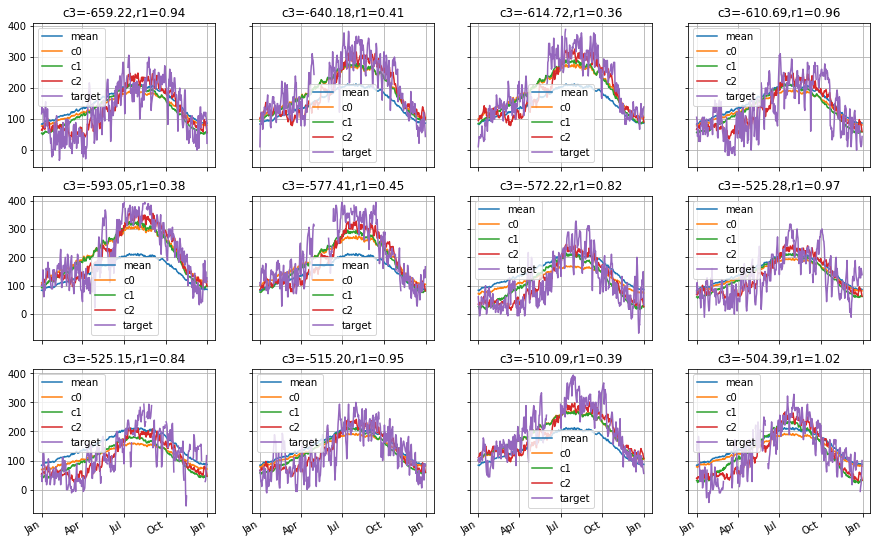

In [112]:
df10 = df3.sort(df3.coeff_3)
rows = df10.take(12)
plot_recon_grid3(rows)

In [68]:
df3 = df3.sort(df3.res_3)
rows = df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
|0.24344119050094234|0.14560464953526675|0.13001772540253032|0.11970183251982042|
| 0.6413021598245635|0.12406349916468698|0.12383119931033078|0.12280958413572693|
| 0.3434918679637472|0.16835006138693867| 0.1478432922213041|0.12413155150567662|
|0.46237093222459874|0.13524965642888262|0.12968860937092713|0.12868005182876444|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


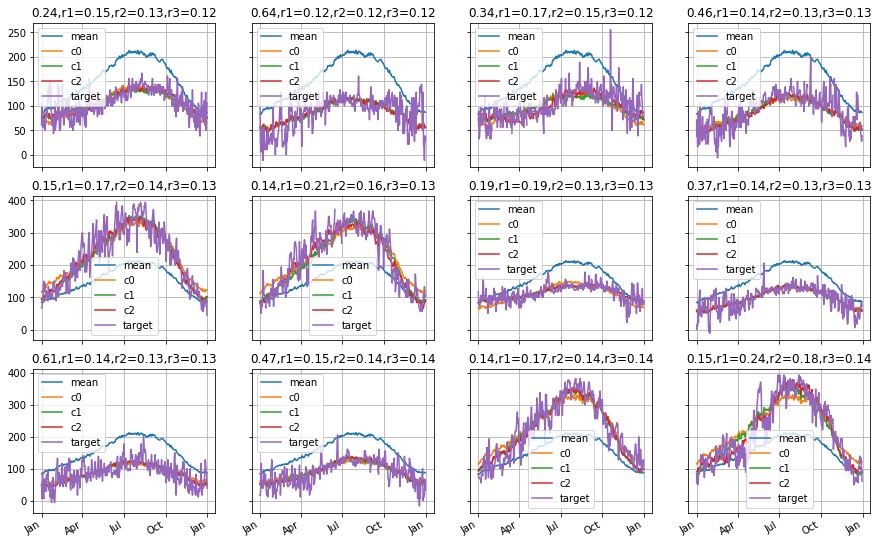

In [69]:
plot_recon_grid(rows)

In [70]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+------------------+------------------+------------------+
|           res_mean|             res_1|             res_2|             res_3|
+-------------------+------------------+------------------+------------------+
|0.06107409531577665|1.5841826948085125| 1.385533858652693|1.3860836076711727|
|0.06392884255105173| 1.228662451897743|1.2282398959597114| 1.209397535017229|
|0.04394238788711916| 0.945960233018999|0.9426429947719069|1.1600466266317173|
|0.04695645866267133|1.2201251082723357|1.0607194557210788| 1.153288942465568|
+-------------------+------------------+------------------+------------------+
only showing top 4 rows



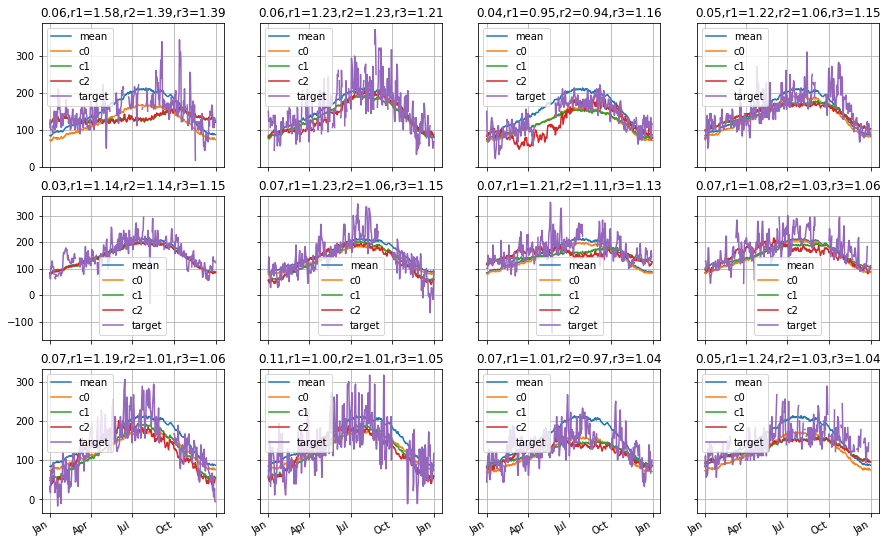

In [71]:
plot_recon_grid(rows)

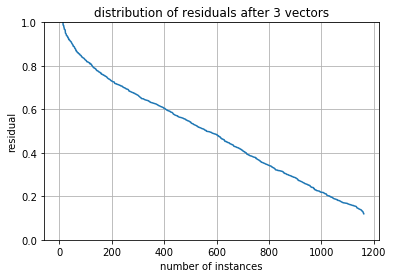

In [72]:
# How well-explained are the vectors in this collection?
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [73]:
filename=data_dir+'/decon_%s_%s.parquet'%(file_index, m)
!rm -rf $filename
df3.write.parquet(filename)

In [74]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.0M	../../Data/Weather/US_Weather_SSSBSSSS.parquet
3.8M	../../Data/Weather/US_Weather_SSSSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSBSSSS_PRCP.parquet
3.1M	../../Data/Weather/decon_SSSBSSSS_TOBS.parquet


# 5 map

In [75]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [78]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df =sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

1163
+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|            coeff_2|          coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|-22.491902889018327|  755.8168283586717|299.3422267183406|    256.9|SSSBSSSS|  36.875|-120.9386|       TOBS|0.9980517005957089|0.6043223056567814|0.5477311205546476|0.14486969424118953|USC00045119|1.0558484E7|     6|[30 54 40 56 A0 5...|1936.0|
|  -652.284

In [80]:
#extract longitude and latitude for each station
feature = 'coeff_1'
sqlContext.registerDataFrameAsTable(df,'tobs')
Query="SELECT station, latitude, longitude, elevation, %s FROM tobs"%feature
print(Query)
df_f = sqlContext.sql(Query)
df_f.show(4)

SELECT station, latitude, longitude, elevation, coeff_1 FROM tobs
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00045119|  36.875|-120.9386|    256.9|-22.491902889018327|
|USC00040674| 37.0833|   -122.1|    153.0|  -652.284878090936|
|USC00041534| 36.4806|-121.7244|    146.3|-480.38734959690373|
|USC00045933| 37.3436|-121.6425|   1282.0| 315.07577603915263|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [81]:
df_g = df_f.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf = df_g.toPandas()
pdf.sort_values(by = ['station'], inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
30,USC00040673,37.0856,-122.0797,128.0,40,-617.256721
24,USC00040674,37.0833,-122.1000,153.0,28,-34.058895


In [82]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#df0000'

# Map

In [84]:
min_lat = pdf['latitude'].min()
max_lat = pdf['latitude'].max()
min_long = pdf['longitude'].min()
max_long = pdf['longitude'].max()
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

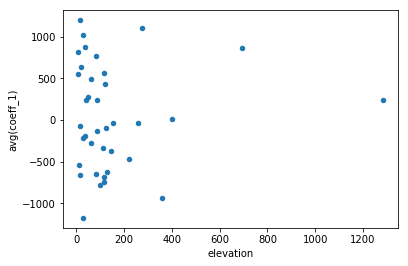

In [85]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [86]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']

In [87]:
from leaflet import *

In [88]:
# RECONSTRUCTION USING TOP EIGENVECTORS
import gzip
with open(data_dir+'/TOBS_residuals_PCA.pickle','rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
inF = gzip.GzipFile(data_dir+'/stations.pkl.gz', 'rb')
s = inF.read()
inF.close()

outF = open(data_dir+'/stations.pkl', 'wb')
outF.write(s)
outF.close()
with open(data_dir+'/stations.pkl','rb') as file:
    Stations = load(file)
Stations.head()


['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [89]:
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3
0,0.047616,0.110037,0.014540,0.022591
1,-0.388769,0.052047,0.029536,0.347882
2,0.046645,0.115114,0.012724,0.069578
3,0.046645,0.115114,0.012724,0.069578
4,0.046738,0.114472,0.012366,0.071532


In [90]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00043714', u'USC00040673', u'USC00040677', u'USC00049792', u'USC00047807']


,0,1,2,3
station,,,,
USC00043714,0.047616,0.110037,0.014540,0.022591
USC00040673,-0.388769,0.052047,0.029536,0.347882
USC00040677,0.046645,0.115114,0.012724,0.069578
USC00049792,0.046645,0.115114,0.012724,0.069578
USC00047807,0.046738,0.114472,0.012366,0.071532


In [91]:
table=Eig.join(Stations,how='left')
table=table[['name','latitude','longitude','elevation',0,1,2,3]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00043714,HALF MOON BAY,37.4725,-122.4433,8.2,0.047616,0.110037,0.014540,0.022591
USC00040673,BEN LOMOND #4,37.0856,-122.0797,128.0,-0.388769,0.052047,0.029536,0.347882
USC00040677,BEN LOMOND 4,37.0833,-122.0667,220.1,0.046645,0.115114,0.012724,0.069578
USC00049792,WOODSIDE FIRE STN 1,37.4286,-122.2561,115.8,0.046645,0.115114,0.012724,0.069578


In [93]:
## MAP
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
min_lat = pdf['latitude'].min()
max_lat = pdf['latitude'].max()
min_long = pdf['longitude'].min()
max_long = pdf['longitude'].max()
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly   
m    

In [95]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [113]:
Features='station, year, coeff_1'
Query="SELECT %s FROM tobs" % Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_1 FROM tobs


,station,year,coeff_1
0,USC00045119,1936.0,-22.491903
1,USC00040674,1943.0,-652.284878
2,USC00041534,2011.0,-480.387350
3,USC00045933,1999.0,315.075776
4,USC00045123,1937.0,496.369921


In [115]:
year_station_table = pdf.pivot(index='year', columns='station', values='coeff_1')
year_station_table.head(10)

station,USC00040673,USC00040674,USC00040676,USC00040677,USC00040790,USC00041534,USC00042362,USC00043004,USC00043417,USC00043714,...,USC00047668,USC00047807,USC00047821,USC00047846,USC00047912,USC00047916,USC00048273,USC00049473,USC00049792,USW00023259
year,,,,,,,,,,,,,,,,,,,,,
1901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,867.183263,NaN,NaN,NaN,NaN
1902.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,233.585829,NaN,NaN,NaN,NaN,NaN
1904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-42.166134,NaN,NaN,NaN,NaN,NaN
1905.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,78.805965,NaN,NaN,NaN,NaN,NaN
1906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,189.586487,NaN,NaN,NaN,NaN,NaN
1907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,67.816750,NaN,NaN,NaN,NaN,NaN
1908.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,155.592672,NaN,NaN,NaN,NaN,NaN
1909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,94.679266,NaN,NaN,NaN,NaN,NaN


In [116]:
mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

total RMS                   =  707.100124098
RMS removing mean-by-station=  380.777409608
RMS removing mean-by-year   =  668.246162667


In [96]:
#extract longitude and latitude for each station
feature='coeff_1'
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_2'
Query="SELECT %s FROM tobs" % Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM tobs


,station,year,coeff_2
0,USC00045119,1936.0,755.816828
1,USC00040674,1943.0,-175.520344
2,USC00041534,2011.0,-508.709210
3,USC00045933,1999.0,318.540177
4,USC00045123,1937.0,279.293933


In [97]:
year_station_table = pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.head(10)

station,USC00040673,USC00040674,USC00040676,USC00040677,USC00040790,USC00041534,USC00042362,USC00043004,USC00043417,USC00043714,...,USC00047668,USC00047807,USC00047821,USC00047846,USC00047912,USC00047916,USC00048273,USC00049473,USC00049792,USW00023259
year,,,,,,,,,,,,,,,,,,,,,
1901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-153.979179,NaN,NaN,NaN,NaN
1902.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-305.129256,NaN,NaN,NaN,NaN,NaN
1904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-248.289661,NaN,NaN,NaN,NaN,NaN
1905.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-389.874183,NaN,NaN,NaN,NaN,NaN
1906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-249.844991,NaN,NaN,NaN,NaN,NaN
1907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-360.464185,NaN,NaN,NaN,NaN,NaN
1908.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-278.198649,NaN,NaN,NaN,NaN,NaN
1909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-302.846597,NaN,NaN,NaN,NaN,NaN


In [98]:
# Estimating the effect of the year vs the effect of the station
mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

total RMS                   =  286.083532778
RMS removing mean-by-station=  129.759224797
RMS removing mean-by-year   =  267.014357208


In [117]:
Features='station, year, coeff_3'
Query="SELECT %s FROM tobs" % Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_3 FROM tobs


,station,year,coeff_3
0,USC00045119,1936.0,299.342227
1,USC00040674,1943.0,20.324319
2,USC00041534,2011.0,-201.173189
3,USC00045933,1999.0,-659.222898
4,USC00045123,1937.0,59.163594


In [118]:
year_station_table = pdf.pivot(index='year', columns='station', values='coeff_3')
year_station_table.head(10)

station,USC00040673,USC00040674,USC00040676,USC00040677,USC00040790,USC00041534,USC00042362,USC00043004,USC00043417,USC00043714,...,USC00047668,USC00047807,USC00047821,USC00047846,USC00047912,USC00047916,USC00048273,USC00049473,USC00049792,USW00023259
year,,,,,,,,,,,,,,,,,,,,,
1901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,133.243815,NaN,NaN,NaN,NaN
1902.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-55.817191,NaN,NaN,NaN,NaN,NaN
1904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,136.673430,NaN,NaN,NaN,NaN,NaN
1905.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,88.562117,NaN,NaN,NaN,NaN,NaN
1906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-369.029702,NaN,NaN,NaN,NaN,NaN
1907.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-7.353634,NaN,NaN,NaN,NaN,NaN
1908.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,61.944962,NaN,NaN,NaN,NaN,NaN
1909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-19.176336,NaN,NaN,NaN,NaN,NaN


In [119]:
mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year)

total RMS                   =  167.3190488
RMS removing mean-by-station=  146.80645052
RMS removing mean-by-year   =  131.740235653


In [99]:
T = year_station_table
print 'initial RMS=',RMS(T)
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)

initial RMS= 286.083532778
0 after removing mean by year    = 267.014357208
0 after removing mean by stations= 117.391590204
1 after removing mean by year    = 108.281387395
1 after removing mean by stations= 106.743520771
2 after removing mean by year    = 106.317315008
2 after removing mean by stations= 106.175155318
3 after removing mean by year    = 106.121594295
3 after removing mean by stations= 106.099216403
4 after removing mean by year    = 106.088987666
4 after removing mean by stations= 106.083958599
